In [5]:
import torch
from torch import nn, optim, Generator
from torch.utils.data import DataLoader, Dataset, random_split
from numpy.random import choice
from typing import Iterable, Callable, Type, Optional, Union, Tuple, List

In [158]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder


In [7]:
# download data(zipped csv) from kaggle with username and apikey
# import os
# import json
# from kaggle.api.kaggle_api_extended import KaggleApi
# with open("./kaggle.json", "r") as j:
#     for (k, v) in json.load(j).items():
#         os.environ[k] = v
# api = KaggleApi()
# api.authenticate()
# # https://www.kaggle.com/competitions/cafa-5-protein-function-prediction
# # datasetname
# api.dataset_download_files('arnabchaki/data-science-salaries-2023', path="./data/", unzip=True)

In [8]:
from operator import mul


def product(nums: Iterable[Type], func: Callable[[Type, Type], Type] = mul) -> Type:
    """return product of iterable"""
    _it = iter(nums)
    v: Type = next(_it)
    for _v in _it:
        v = func(v, _v)
    return v

In [240]:
class DS_SalaryDataset(Dataset):
    """DS Salary dataset."""

    def __init__(self, csv_path="./data/ds_salaries.csv"):
        """
        Args:
            csv_path (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ds_salaries: pd.DataFrame = pd.read_csv(csv_path)
        self.nonnumerical_columns = [
            c for c, dt in self.ds_salaries.dtypes.items() if dt == 'O']
        for c in self.nonnumerical_columns:
            self.ds_salaries = pd.get_dummies(
                self.ds_salaries, prefix=[c], columns=[c], drop_first=True)
        # drop work_year salary salary_in_usd
        # normalization
        self.feature = nn.functional.normalize(torch.from_numpy(
            self.ds_salaries[self.ds_salaries.columns[3:]].to_numpy(dtype=np.float32)), dim=0)

        # target: salary_in_usd
        self.salary = torch.reshape(torch.tensor(
            self.ds_salaries.salary_in_usd.to_numpy(dtype=np.float32)), shape=(self.ds_salaries.salary_in_usd.size,))

    def __len__(self):
        return self.salary.size()[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.feature[idx], self.salary[idx]


def getCustomizedData():
    # preprocess
    dataset = DS_SalaryDataset()
    # train test split
    train_count = int(0.7 * len(dataset))
    valid_count = int(0.2 * len(dataset))
    test_count = len(dataset) - train_count - valid_count
    print(train_count, valid_count, test_count)
    trainset, valset, testset = random_split(
        dataset, (train_count, valid_count, test_count), Generator().manual_seed(42))
    datum_size = product(trainset[0][0].size())
    return trainset, valset, testset, datum_size

In [10]:
from collections import deque


class TwoLayerNetwork(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int, init_method: Callable[[torch.Tensor], torch.Tensor], active_func: Callable[[], nn.modules.module.Module],
                 DO: float, if_BN: bool, store_size: int = 1):
        super(TwoLayerNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.if_BN = if_BN
        # dropout
        self.do = nn.Dropout(DO)
        # first layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # batch norm
        self.bn1 = nn.BatchNorm1d(hidden_size)
        # activation
        self.active_func = active_func()
        # second layer
        self.fc2 = nn.Linear(hidden_size, num_classes)
        # initialize
        for param in self.parameters():
            init_method(param)
        self.storage: deque[List[nn.Parameter]] = deque(maxlen=store_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out: torch.Tensor = self.do(x)
        out = self.fc1(out)
        if self.if_BN:
            out = self.bn1(out)
        out = self.active_func(out)
        out = self.fc2(out)
        return out

In [41]:
class WD_Regularization(nn.Module):
    def __init__(self):
        super(WD_Regularization, self).__init__()


class L2_Regularization(WD_Regularization):
    def __init__(self, weight_decay: float):
        super(L2_Regularization, self).__init__()
        if weight_decay <= 0:
            raise ValueError("param weight_decay can not <=0!!")
        self.weight_decay = weight_decay

    def forward(self, model: nn.Module) -> Union[torch.Tensor, float]:
        reg = 0
        for name, parameter in model.named_parameters():
            if name in ("fc1.weight", "fc2.weight"):
                reg += torch.sum(parameter**2)
        return self.weight_decay * reg


In [202]:
def validate(model: TwoLayerNetwork, device: str, valset: Dataset[torch.Tensor], criterion: nn.modules.loss._Loss) \
        -> Tuple[float, float]:
    """return loss, accuracy"""
    # Validate the model
    model.to(device)
    criterion.to(device)
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for x, y in DataLoader(valset, batch_size=32, shuffle=True):
            x: torch.Tensor = x.view(-1, model.input_size).to(device)
            y: torch.Tensor = y.to(device)
            outputs: torch.Tensor = model(x)
            loss: torch.Tensor = criterion(outputs, y)**0.5
            val_loss += loss.item() * x.size(0)
        val_loss /= len(valset)
    return val_loss

In [201]:
def train(model: TwoLayerNetwork, opt: Callable[..., optim.Optimizer], device: str, epochs: float, learning_rate: float, trainset: Dataset[torch.Tensor], valset: Dataset[torch.Tensor], criterion: nn.modules.loss._Loss,
          sched: Optional[Callable[[optim.Optimizer], optim.lr_scheduler._LRScheduler]], wd_reg: Optional[WD_Regularization], learning_goal: float, min_lr: float, if_lr_adjust: bool, if_BN: bool, drop_rate: float) \
        -> List[Tuple[float, float, float, float]]:
    """
    Params:
        model
        opt
        device
        epochs
        learing_rate
        criterion
        y: label of data
        wd_reg, BN, DO: regularization
    Results:
        history: train_loss, train_accuracy, val_loss, val_accuracy of each epochs
    """
    def forward_backward(optimizer: optim.Optimizer, criterion: nn.modules.loss._Loss, wd_reg: Optional[WD_Regularization], model: TwoLayerNetwork, y: torch.Tensor,
                         BN: Optional[nn.modules.batchnorm._BatchNorm], DO: Optional[nn.modules.dropout._DropoutNd]) \
            -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Params:
            optimizer
            criterion
            model
            y: label of data
            wd_reg, BN, DO: regularization
        Results:
            ouputs: f(x)
            loss_all: f(x) - y
        """
        optimizer.zero_grad()
        outputs = model(x)
        outputs = outputs if not DO else DO(outputs)
        loss_all: torch.Tensor = criterion(
            outputs, y)**0.5 + wd_reg(model) if wd_reg else criterion(outputs, y)**0.5
        loss_all.backward()
        optimizer.step()
        return loss_all, outputs
    if epochs < 1:
        raise ValueError("Invalid epoch!!")
    if not 0 <= drop_rate < 1:
        raise ValueError("Invalid dropout rate!!")
    # init
    epoch = 0
    init_lr = learning_rate
    origin_if_BN = model.if_BN
    model.if_BN = if_BN
    pre_loss = float("inf") if if_lr_adjust else None
    batch_norm = nn.BatchNorm1d(model.hidden_size).to(
        device) if if_BN else None
    drop_out = nn.Dropout(drop_rate).to(device) if drop_rate != 0. else None
    model.to(device)
    # if not model.storage[-1]
    model.storage.append(list(model.parameters()))
    optimizer = opt(model.storage[-1], lr=learning_rate)
    scheduler = sched(optimizer) if sched else None
    history = []
    # Train the model
    while epoch < epochs:
        train_loss = 0.0
        train_correct = 0
        model.train()
        for x, y in DataLoader(trainset, batch_size=32, shuffle=True):
            x: torch.Tensor = x.view(-1, model.input_size).to(device)
            y: torch.Tensor = y.to(device=device, dtype=torch.float32)
            loss_all, outputs = forward_backward(
                optimizer, criterion, wd_reg, model, y, batch_norm, drop_out)
            # Learning rate adjustment
            if pre_loss:
                while pre_loss <= loss_all.item():
                    # learning rate vanishing
                    if learning_rate < min_lr:
                        # return history
                        learning_rate = init_lr
                        optimizer = opt(model.storage[-1], lr=learning_rate)
                        loss_all, outputs = forward_backward(
                            optimizer, criterion, wd_reg, model, y, batch_norm, drop_out)
                        # raise ValueError(f"{learning_rate} < {min_lr}")
                        break
                    learning_rate *= 0.7
                    optimizer = opt(model.storage[-1], lr=learning_rate)
                    loss_all, outputs = forward_backward(
                        optimizer, criterion, wd_reg, model, y, batch_norm, drop_out)
                learning_rate *= 1.2
                pre_loss = loss_all.item()
            train_loss += loss_all.item() * x.size(0)
            model.storage.append(list(model.parameters()))
        train_loss /= len(trainset)
        # Validate the model
        val_loss = validate(
            model=model, device=device, valset=valset, criterion=criterion)
        # Log statics
        history.append((train_loss, val_loss))
        # Stopping criteria
        if learning_goal > train_loss:
            return history
        # Update loop
        if scheduler:
            scheduler.step()
        epoch += 1
    # restore model
    model.if_BN = origin_if_BN
    return history

In [46]:
def test(model: TwoLayerNetwork, device: str, testset: Dataset[torch.Tensor]) -> float:
    """return accuracy"""
    return validate(model=model, device=device, valset=testset, criterion=nn.MSELoss())

In [15]:
def analogizing(model: TwoLayerNetwork, device: str, trainset: Dataset[torch.Tensor], learning_goal: float, criterion: nn.modules.loss._Loss):
    x = torch.stack([x for x, _ in trainset]
                    ).view(-1, model.input_size).to("cpu")
    y = torch.Tensor([y for _, y in trainset]).to("cpu")
    total_amount = len(x)
    # get wrong correct indices
    new_fc1_w = model.fc1.weight.data.to(device)
    new_fc1_b = model.fc1.bias.data.to(device)
    new_fc2_w = model.fc2.weight.data.to(device)
    relu = nn.ReLU()
    logits: torch.Tensor = x
    model.eval()
    with torch.no_grad():
        outputs = relu(x.to(device) @ new_fc1_w.T + new_fc1_b
                       ) @ new_fc2_w.T + model.fc2.bias.data.to(device)
        logits, predicted = torch.max(outputs.data, 1)
        success_condition = predicted == y.to(device)
        wrong_indices = torch.nonzero(success_condition != True).to("cpu")
    #
    init_func: Callable[[torch.Tensor], torch.Tensor] = lambda x: nn.init.xavier_uniform_(
        tensor=x) if len(x.shape) > 1 else x
    wrong_pointer = len(wrong_indices)
    train_correct: int = 0
    loss: float = float("inf")
    history: List[Tuple[float, float]] = []
    while wrong_pointer > 0 and loss > learning_goal:
        fc1 = nn.Linear(len(x[0]), 3).to(device)
        fc2 = nn.Linear(3, product(model.fc2.bias.size()),
                        False).to(device)
        # with torch.no_grad():
        target = torch.zeros(*torch.Size((total_amount,)))
        wrong_pointer -= 1
        pointer = wrong_indices[wrong_pointer]
        catagory = int(y[pointer])
        target[pointer] = catagory
        target = target.to(device)
        fc2.weight.data[:, :] = 0
        fc2.weight.data[catagory, 0] = -2
        fc2.weight.data[catagory, 1] = 1
        fc2.weight.data[catagory, 2] = 1
        delta = 0
        intercept = 0
        nonz = x
        # randomly generate hyperplane which only contain the target x
        while nonz.size() != (1, 2) or nonz.tolist()[0][0] != pointer:
            for p in fc1.parameters():
                init_func(p)
            distances = x.to(device) @ fc1.weight.data[0].T
            intercept = distances[pointer]
            distances -= intercept
            # get the shortest distance of other x to hyperplane
            if (delta := torch.min(torch.abs(torch.cat(
                    (distances[:pointer], distances[pointer + 1:])
            )))) == 0:
                continue
            fc1.bias.data[1] = -intercept + (delta / 2)
            fc1.bias.data[2] = -intercept - (delta / 2)
            # check if delta too small for float32(default)
            if fc1.bias.data[1] == fc1.bias.data[2]:
                continue
            fc1.bias.data[0] = -intercept
            fc1.weight.data[1:] = fc1.weight.data[0]
            outputs = relu(x.to(device) @ fc1.weight.data.T + fc1.bias.data
                           ) @ fc2.weight.data.T
            nonz = torch.nonzero(outputs)
        # adjust weight in order to make the output of correct category greater than the others
        fc2.weight.data *= logits[pointer].item(
        ) / outputs[pointer].sum() + 1
        new_fc1_w = torch.cat((new_fc1_w, fc1.weight.data)).to(device)
        new_fc1_b = torch.cat((new_fc1_b, fc1.bias.data)).to(device)
        new_fc2_w = torch.cat((new_fc2_w, fc2.weight.data), 1).to(device)
        with torch.no_grad():
            outputs = relu(x.to(device) @ new_fc1_w.T + new_fc1_b
                           ) @ new_fc2_w.T + model.fc2.bias.data.to(device)
            loss = criterion(
                outputs, y.to(device=device, dtype=torch.long)).item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct = (predicted == y.to(device)).sum().item()
        history.append((loss, train_correct / total_amount))
    # construct new model
    new_model = TwoLayerNetwork(model.input_size, len(new_fc1_b), product(
        model.fc2.bias.size()), lambda _: _, lambda: model.active_func, model.do.p, model.if_BN)
    for name, param in model.named_parameters():
        layer_name, variable_type = name.split(".")
        if layer_name == "fc1":
            setattr(getattr(getattr(new_model, layer_name), variable_type),
                    "data", eval(f"new_{layer_name}_{variable_type[0]}"))
        elif layer_name == "fc2":
            if variable_type == "weight":
                setattr(getattr(getattr(new_model, layer_name), variable_type),
                        "data", eval(f"new_{layer_name}_{variable_type[0]}"))
            elif variable_type == "bias":
                new_model.fc2.bias.data[:] = model.fc2.bias.data[:]
            else:
                pass
                setattr(getattr(new_model, layer_name), variable_type, param)
        else:
            setattr(getattr(new_model, layer_name), variable_type, param)
    return new_model


In [241]:
device = "cuda" if torch.cuda.is_available(
) else "mps" if torch.backends.mps.is_available() else "cpu"
trainset, valset, testset, input_size = getCustomizedData()
criterion = nn.MSELoss()


2628 751 376


### Train

In [262]:
hidden_size = 256
epochs = 100
init: Callable[[torch.Tensor], torch.Tensor] = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else x
active = nn.ReLU
model = TwoLayerNetwork(input_size, hidden_size,
                        1, init, active, 0.2, True)
optimize = optim.SGD
schedule = None
learning_rate = 0.001
min_lr = learning_rate * 1e-5
l2_reg = L2_Regularization(0.001)
baseline = test(model, device, testset)
learning_goal = 50000
history = train(model, optimize, device, epochs, learning_rate,
                trainset, valset, criterion, schedule, l2_reg, learning_goal, min_lr, True, True, 0.2)
result = test(model, device, testset)
print(baseline, history, result, sep="\n")
model_path = r"./data/final"
torch.save(model, model_path)

c:\VS_Workplace\NN\venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\VS_Workplace\NN\venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\VS_Workplace\NN\venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(in

150978.45777925532
[(150428.4724362633, 152691.77296937417), (150439.64866343228, 152700.21006366512), (150319.89906773213, 152574.10481857523), (150312.72508799468, 152511.55051597868), (150298.95236396499, 152585.50143558587), (150232.63737871006, 152542.58763315578), (150267.63628472222, 152485.87645639147), (150341.40712994672, 152425.85818908122), (150130.35527254565, 152387.00902962717), (150158.33701959666, 152213.71219623834), (150127.61560597413, 152187.41555009986), (149878.4955883752, 152087.15675973703), (149520.3413717656, 151696.88885652463), (149150.97039098173, 151104.05249250997), (148304.60715135085, 150287.52328145807), (147565.62811548705, 148225.73094207724), (145846.3625975076, 147300.8214464048), (143367.65151731356, 144219.69906790945), (139808.21527777778, 139126.13712966046), (134765.82926655252, 133376.96296604528), (127798.2366699962, 125240.82454643809), (119482.15108923135, 116513.47263544441), (109320.54777872907, 105021.00262150467), (100464.22951151065,

In [194]:
dataset = DS_SalaryDataset()


In [263]:
model.to(device)
model.eval()
with torch.no_grad():
    for x, y in DataLoader(dataset, batch_size=len(dataset)):
        outputs: torch.Tensor = model(x.view(-1, model.input_size).to(device))

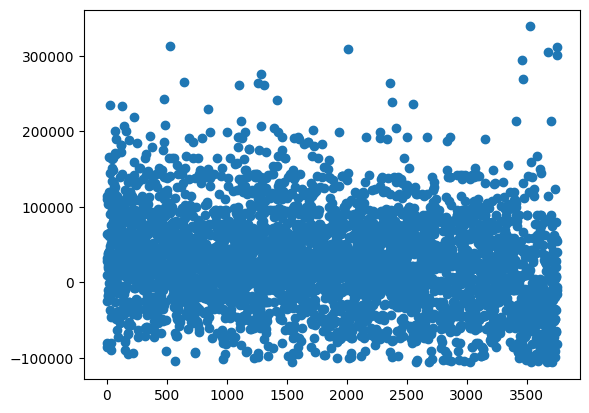

In [264]:
import matplotlib.pyplot as plt
window = len(dataset)
# plt.scatter(range(window), outputs.cpu()[:window])
# plt.scatter(range(window), y.cpu()[:window])
plt.scatter(range(window), (y.cpu()-outputs.cpu().view(y.size()))[:window])
plt.show()

In [189]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [265]:
r2_score(y.cpu(), outputs.cpu())

-0.20913703150977336

In [266]:
mean_squared_error(y.cpu(), outputs.cpu())

4806263000.0

In [267]:
mean_squared_error(y.cpu(), outputs.cpu())**0.5

69327.21531981506

In [268]:
mean_absolute_error(y.cpu(), outputs.cpu())

53838.703

In [ ]:
analogizing(model, device, trainset, learning_goal, criterion)